In [25]:
import numpy as np
import quaternion as qt
import library.utils as ut
import library.ulogReader as ur
import library.quaternionUtils as qu
import library.choleskyDecomposition as cd
import library.quaternionVisualization as qv

from pyulog import ULog

## Wczytanie danych lotu drona

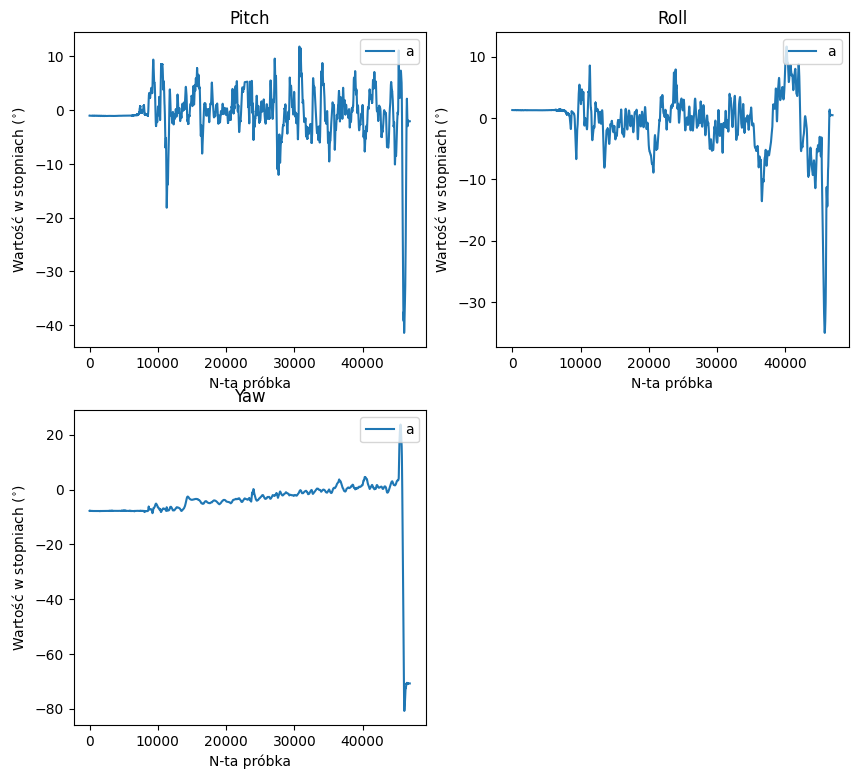

In [26]:
ulog_path = './ulogs/639_bs10_out_alt.ulg'
ulog = ULog(ulog_path)

attitude, attitude_time  = ur.readAttitude(ulog)
attitude_time = (attitude_time - attitude_time[0]) / 1e3

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])


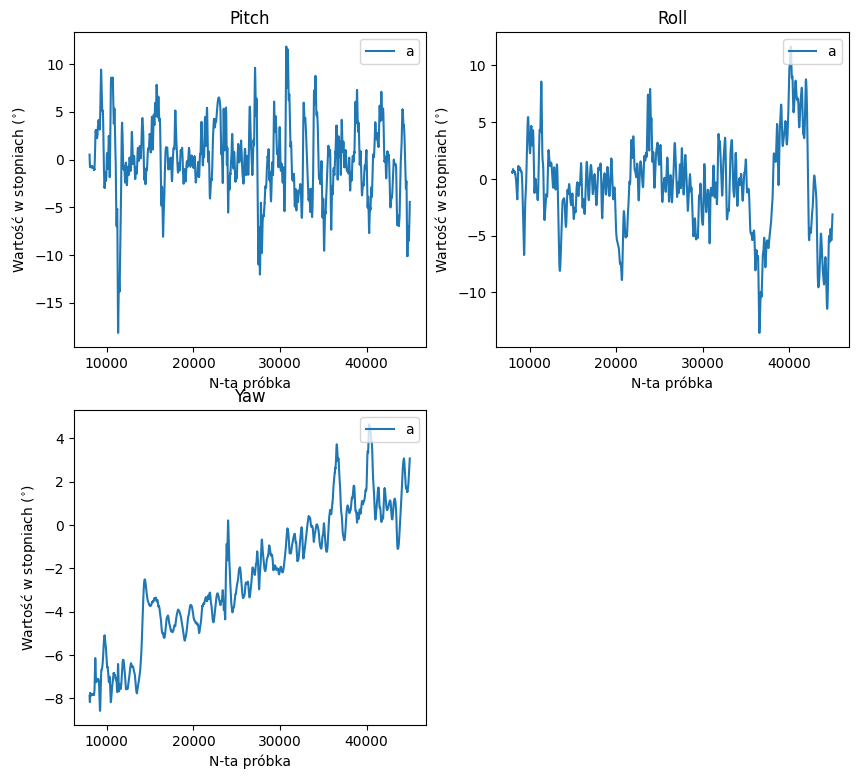

In [27]:
start_time = 8e3   
end_time   = 45e3

# Config interpolation
dt = 2      # Delta time in ms
degree = 3  # Spline degree

# Post resampling time
it_t = np.arange(start_time, end_time, dt)
attitude = qu.splineInterpolation(attitude, attitude_time, it_t, degree)
attitude_time = it_t

qv.display_quat_as_euler([attitude], [attitude_time], ['a'])

In [28]:
P_ORDER    = 5 
K_FORECAST = [1,3,7]
N_WINDOW = 8            # Minimal value (N_WINDOW > P_ORDER + 1)
START_WINDOW = 30
MU = 1e-3

x = np.copy(attitude)[::2]
x_euler = qu.quaternionToEuler(x)
y = np.ones((len(K_FORECAST), x.shape[0] + max(K_FORECAST)), dtype = qt.quaternion)

pitch_corr = ut.correlationMatrixReal(x_euler[:START_WINDOW, 0][::-1], P_ORDER)
roll_corr  = ut.correlationMatrixReal(x_euler[:START_WINDOW, 1][::-1], P_ORDER)
yaw_corr   = ut.correlationMatrixReal(x_euler[:START_WINDOW, 2][::-1], P_ORDER)

for i in range(START_WINDOW, x.shape[0]+1):
    # Pitch 
    tmp_pitch_corr = ut.correlationMatrixReal(x_euler[i-N_WINDOW : i, 0][::-1], P_ORDER)
    pitch_corr = (1-MU) * pitch_corr + MU * tmp_pitch_corr
    p_w = ut.solveEquation(pitch_corr)

    # Roll 
    tmp_roll_corr = ut.correlationMatrixReal(x_euler[i-N_WINDOW : i, 1][::-1], P_ORDER)
    roll_corr = (1-MU) * roll_corr + MU * tmp_roll_corr
    r_w = ut.solveEquation(roll_corr)

    # Yaw 
    tmp_yaw_corr = ut.correlationMatrixReal(x_euler[i-N_WINDOW : i, 2][::-1], P_ORDER)
    yaw_corr = (1-MU) * yaw_corr + MU * tmp_yaw_corr
    y_w = ut.solveEquation(yaw_corr)


    for k, k_steps in enumerate(K_FORECAST):
        pitch = ut.kForecast(np.copy(x_euler[i-P_ORDER : i, 0][::-1]), p_w, k_steps)
        roll  = ut.kForecast(np.copy(x_euler[i-P_ORDER : i, 1][::-1]), r_w, k_steps)
        yaw   = ut.kForecast(np.copy(x_euler[i-P_ORDER : i, 2][::-1]), y_w, k_steps)
        y[k, i + k_steps - 1] = qu.eulerToQuaternion([pitch, roll, yaw])[0]

    #q_w = qu.eulerToQuaternion(np.array(([p_w,r_w,y_w])).T)
    #for k, k_steps in enumerate(K_FORECAST):
    #    y[k, i + k_steps - 1] = qu.predictionKSteps(np.copy(x[i-P_ORDER-1 : i][::-1]), np.concatenate(([qt.quaternion(1,0,0,0)],q_w)), k_steps)


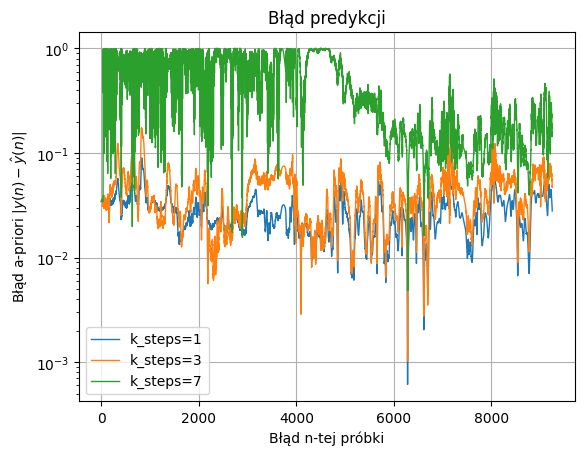

In [29]:
qv.displayPredictionError(x,y,K_FORECAST)